In [ ]:
# Import all required libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from scipy import stats

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Read and Analize datasets**

In [ ]:
# Read the dataset
abalon_data = pd.read_csv('/content/drive/MyDrive/Datasets/abalone/data.csv')
abalon_data.head(3)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


In [ ]:
	# FEATURES DESCRIPTION:
  # Sex		nominal			M, F, and I (infant)
	# Length		continuous	mm	Longest shell measurement
	# Diameter	continuous	mm	perpendicular to length
	# Height		continuous	mm	with meat in shell
	# Whole weight	continuous	grams	whole abalone
	# Shucked weight	continuous	grams	weight of meat
	# Viscera weight	continuous	grams	gut weight (after bleeding)
	# Shell weight	continuous	grams	after being dried
	# Rings

In [ ]:
abalon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [ ]:
abalon_data.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Великий розрив значень між mean та min та/або max значеннями говорить про те що можуть бути викиди.

In [ ]:
# Generate a correlation matrix and visualize possible correlations between all columns
correlation_matrix_1 = abalon_data[abalon_data.columns[1:]].corr()
mask1 = np.triu(correlation_matrix_1)

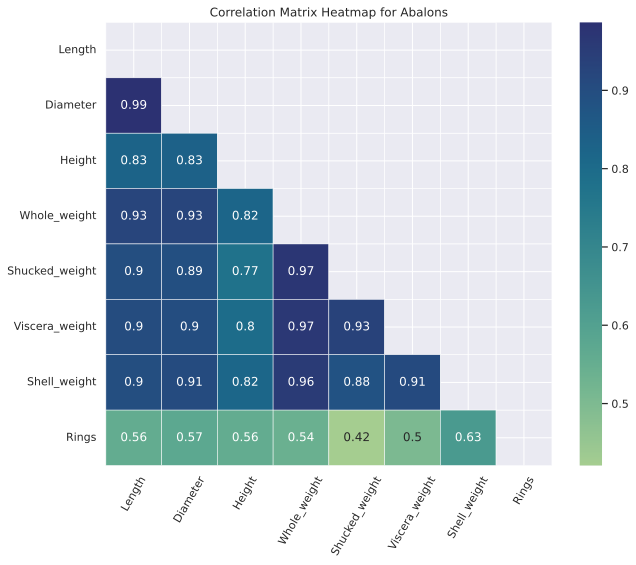

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_1, annot=True, cmap='crest', linewidths=0.5, mask=mask1)
plt.title('Correlation Matrix Heatmap for Abalons')
plt.xticks(rotation=60)
plt.show()

Спостерігаємо впевнену позитивну кореляцію всіх признаків з нашим таргетом 'Rings'

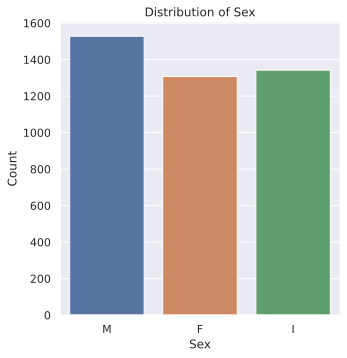

In [ ]:
# Visualize distribution of Sex
sns.catplot(x='Sex', hue='Sex', kind='count', data=abalon_data, legend=False)
plt.title('Distribution of Sex')
plt.xlabel('Sex')
plt.ylabel('Count');

Непоганий баланс класів якщо брати це як таргет для класифікації

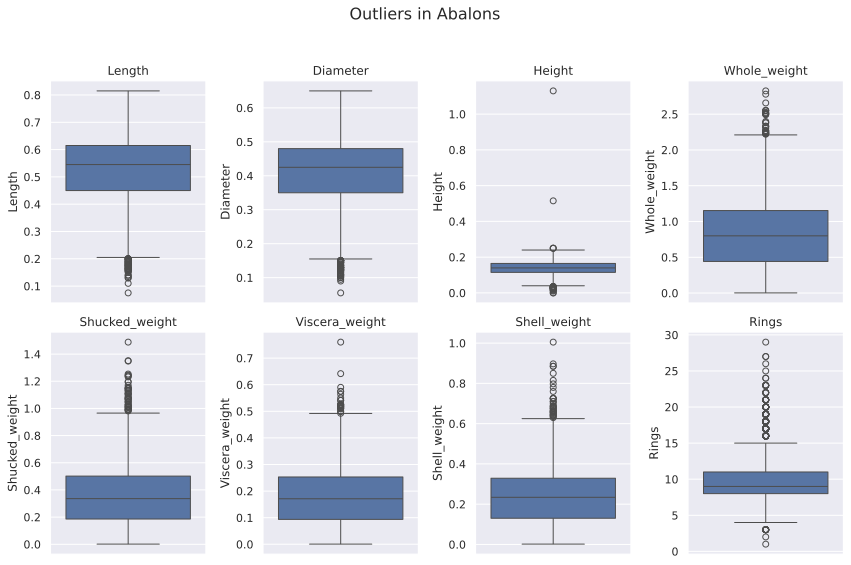

In [ ]:
# Let's check whether the features have outliers
columns = abalon_data.columns[1:]  # Excluding 'Sex'

# Set up the figure for the plots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
fig.suptitle('Outliers in Abalons', fontsize=16)

# Generate box plots for each column
for i, col in enumerate(columns):
    sns.boxplot(y=abalon_data[col], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Майже всі признаки мають викиди, іноді як наприклад у '**Height**' та '**Rings**' дуже великі у максимальних значеннях. Нас цікавить розподіл признаку '**Rings**', так як це буде наш таргет для моделі регресії.

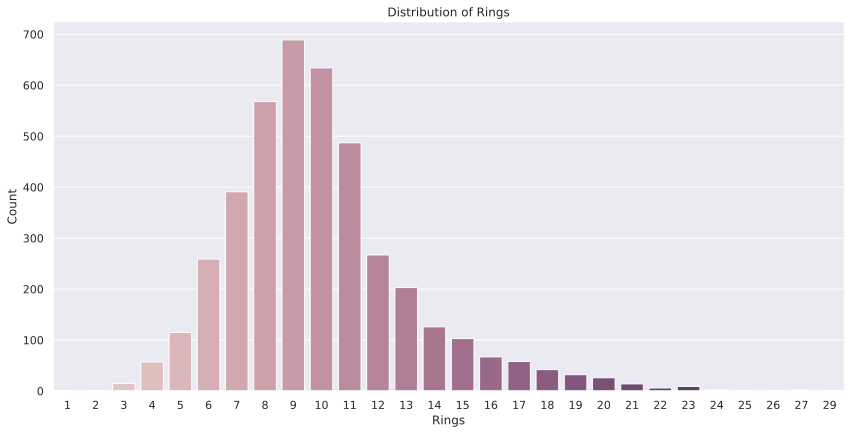

In [ ]:
# Visualize distribution of Rings
sns.catplot(x='Rings', hue='Rings', kind='count', data=abalon_data, legend=False, height=6, aspect=2)  # , ,
plt.title('Distribution of Rings')
plt.xlabel('Rings')
plt.ylabel('Count');

Тут ми хотіли би побачити сбалансовані класи - '**Rings**', тобто щоби всі столбці на графіку були рівной висоти, але як бачимо крайні класи як **1, 2, 25, 26, 29** мають тільки по одному спостереженню. Це погано, так як ми не зможемо навчити модель впевнено знаходити такі класи.

## **2. Clean Data and Feature Engineering**

In [ ]:
# We will experiment with two versions of datasets: original and cleaned off outliers
def preprocess_and_split(df):
    '''
    Transforms categorical data into numerical,
    scale data and split into train, val and test
    sets with 70/20/10 proportion
    '''
    df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df.drop('Rings', axis=1))
    scaled_df = pd.DataFrame(scaled_features, columns=df.drop('Rings', axis=1).columns)
    scaled_df['Rings'] = df['Rings'].values
    # print(scaled_df.shape, scaled_df.head()) # remove

    train_data, temp_data = train_test_split(scaled_df, test_size=0.3, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.33, random_state=42)

    X_train = train_data.drop('Rings', axis=1)
    y_train = train_data['Rings']
    X_val = val_data.drop('Rings', axis=1)
    y_val = val_data['Rings']
    X_test = test_data.drop('Rings', axis=1)
    y_test = test_data['Rings']

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
# Arrange sets from original dataset (with outliers)
X_train_original, y_train_original, X_val_original, y_val_original, X_test_original, y_test_original = preprocess_and_split(abalon_data)

# Arrange sets without outliers that exceed 3 x standard deviations from a mean
z_scores = np.abs(stats.zscore(abalon_data.select_dtypes(include=[np.number])))
filtered_entries = (z_scores < 3).all(axis=1)    # I tried to exclude 'Rings from the outliers filter but result is bad'
abalon_data_cleaned = abalon_data[filtered_entries]

X_train_cleaned, y_train_cleaned, X_val_cleaned, y_val_cleaned, X_test_cleaned, y_test_cleaned = preprocess_and_split(abalon_data_cleaned)

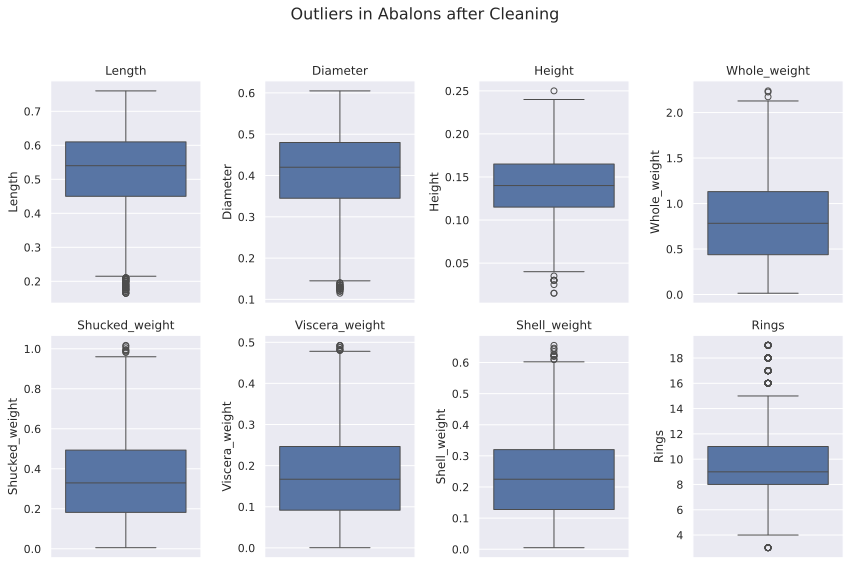

 We have now 4027 lines of observations


In [ ]:
# Let's check our new dataset after outliers have been cleaned
columns_ = abalon_data_cleaned.columns[1:]  # Excluding 'Sex'

# Set up the figure for the plots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
fig.suptitle('Outliers in Abalons after Cleaning', fontsize=16)

# Generate box plots for each column
for i, col in enumerate(columns_):
    sns.boxplot(y=abalon_data_cleaned[col], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f" We have now {abalon_data_cleaned.shape[0]} lines of observations")

## **3. Build Metric Regression Models**

In [ ]:
# Train and evaluate two versions of the KNeighborsRegressor models
def train_and_eval(X_train, y_train, X_val, y_val, X_test, y_test):
    '''
    Fit a model, search for best parameters using GridSearchCV, evaluate model
    with MSE and RMSE
    '''
    # Initialize regressor
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)

    # Grid search parameters
    param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 15], 'weights': ['uniform', 'distance'], 'metric': ['minkowski']}
    grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Use best parameters
    best_knn = grid_search.best_estimator_
    y_test_pred = best_knn.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    return best_knn, round(val_mse, 2), round(test_mse, 2), round(rmse, 2)

In [ ]:
# Evaluate model - outliers were not removed
metrics_original = train_and_eval(X_train_original, y_train_original, X_val_original, y_val_original, X_test_original, y_test_original)

print(f"Best parameters for KNN based on original data: {metrics_original[0]} \nMetrics of model trained on data with outliers:\n"
f"MSE val: {metrics_original[1]},\nMSE test: {metrics_original[2]},\nRMSE: {metrics_original[3]}")
print("#" * 20)

# Evaluate the model - outliers removed
metrics_filtered = train_and_eval(X_train_cleaned, y_train_cleaned, X_val_cleaned, y_val_cleaned, X_test_cleaned, y_test_cleaned)

print(f"Best parameters for KNN based on cleaned data: {metrics_filtered[0]} \nMetrics of model trained on data with outliers:\n"
f"MSE val: {metrics_filtered[1]},\nMSE test: {metrics_filtered[2]},\nRMSE: {metrics_filtered[3]}")

Best parameters for KNN based on original data: KNeighborsRegressor(n_neighbors=11, weights='distance') 
Metrics of model trained on data with outliers:
MSE val: 4.8,
MSE test: 5.28,
RMSE: 2.3
####################
Best parameters for KNN based on cleaned data: KNeighborsRegressor(n_neighbors=15, weights='distance') 
Metrics of model trained on data with outliers:
MSE val: 4.4,
MSE test: 4.38,
RMSE: 2.09


Явно що модель натренована на даних без викидів показує кращу якість.

## **4. Build Metric Calssification Model**

### 4.1. Clean Data

In [ ]:
# Remove outliers
def filter_outliers(df, exclude_cols):
    '''
    Filter outliers from numerical features
    using Interquartile Range
    '''
    Q1 = df.drop(columns=exclude_cols).quantile(0.25)
    Q3 = df.drop(columns=exclude_cols).quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df.drop(columns=exclude_cols) < (Q1 - 1.5 * IQR)) | (df.drop(columns=exclude_cols) > (Q3 + 1.5 * IQR))).any(axis=1)]

# Exclude 'Sex' feature from the filter
abalon_data_filtered = filter_outliers(abalon_data, exclude_cols=['Sex'])

original_shape = abalon_data.shape
filtered_shape = abalon_data_filtered.shape
print(f"Original shape: {original_shape}, \nFiltered shape: {filtered_shape}")


Original shape: (4177, 9), 
Filtered shape: (3781, 9)


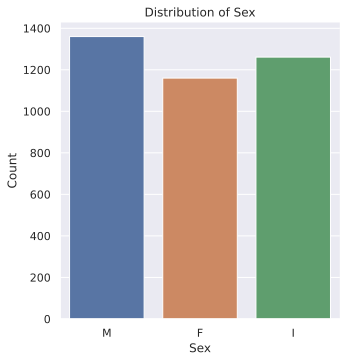

In [ ]:
# Visualize distribution of Sex after cleaning
sns.catplot(x='Sex', hue='Sex', kind='count', data=abalon_data_filtered, legend=False)
plt.title('Distribution of Sex')
plt.xlabel('Sex')
plt.ylabel('Count');

### 4.2. Split Data

In [ ]:
# Define the target
X_2 = abalon_data_filtered.drop('Sex', axis=1)
y_2 = abalon_data_filtered['Sex']

# Scale the features
scaler_2 = StandardScaler()
X_scaled_2 = scaler_2.fit_transform(X_2)

# Split the dataset into training (70%), valid (20%), and test (10%) sets
X_train_2, X_temp_2, y_train_2, y_temp_2 = train_test_split(X_scaled_2, y_2, test_size=0.3, random_state=42)
X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(X_temp_2, y_temp_2, test_size=0.3333, random_state=42)

# Display the shapes of the splits
train_shape = X_train_2.shape
val_shape = X_val_2.shape
test_shape = X_test_2.shape
print(f"Train set shape: {train_shape}, \nValidation set shape: {val_shape}, \nTest set shape: {test_shape}")

Train set shape: (2646, 8), 
Validation set shape: (756, 8), 
Test set shape: (379, 8)


### 4.3. Train Model and Evaluate

In [ ]:
# Define the range of parameters for GridSearchCV
param_grid_2 = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Initialize the classifier
knn_cls = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search_2 = GridSearchCV(estimator=knn_cls, param_grid=param_grid_2, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_2.fit(X_train_2, y_train_2)

# Get the best parameters
best_params_2 = grid_search_2.best_params_

# Evaluate the best model on the val and test sets
best_knn_2 = grid_search_2.best_estimator_
y_val_pred_best_2 = best_knn_2.predict(X_val_2)
val_report_best = classification_report(y_val_2, y_val_pred_best_2)

y_test_pred_best_2 = best_knn_2.predict(X_test_2)
test_report_best = classification_report(y_test_2, y_test_pred_best_2)

print("Best Parameters:", best_params_2)
print("Validation Report:\n", val_report_best)
print("Test Report:\n", test_report_best)

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
Validation Report:
               precision    recall  f1-score   support

           F       0.39      0.40      0.39       204
           I       0.70      0.78      0.74       282
           M       0.49      0.43      0.46       270

    accuracy                           0.55       756
   macro avg       0.53      0.54      0.53       756
weighted avg       0.54      0.55      0.55       756

Test Report:
               precision    recall  f1-score   support

           F       0.47      0.54      0.50       118
           I       0.71      0.77      0.74       123
           M       0.54      0.43      0.48       138

    accuracy                           0.58       379
   macro avg       0.57      0.58      0.57       379
weighted avg       0.57      0.58      0.57       379



* Збалансована метрика F1 на валідаційному датасеті = 0.53 (53%)
* Збалансована метрика F1 на тестовому датасеті = 0.57 (57%)
* По класам модель краще всього знаходить І - 'Infant'

### 4.4. Visualize the Results

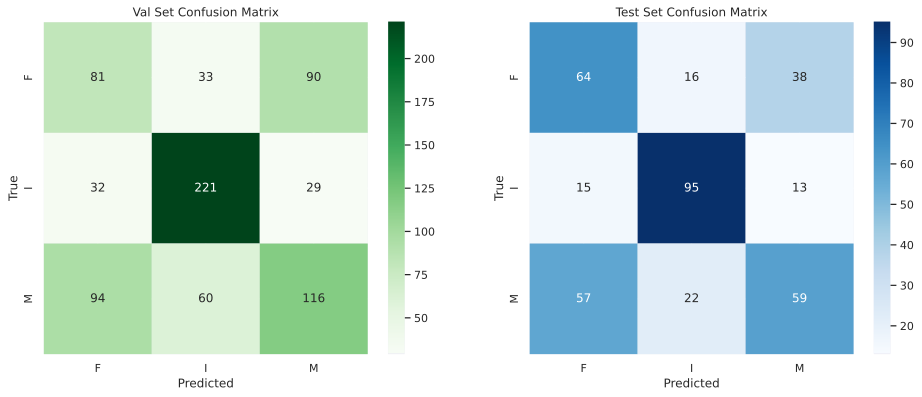

In [ ]:
# Plot the confusion matries for the validation and test sets
def plot_confusion_matrices(y_val_true, y_val_predicted, y_test_true, y_test_predicted, classes):
    '''
    Visualize both confusion matrices for val and test sets
    '''
    # Set common figure size  for plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot for val set
    cm_val = confusion_matrix(y_val_true, y_val_predicted, labels=classes)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes, ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Val Set Confusion Matrix')

    # Plot for test set
    cm_test = confusion_matrix(y_test_true, y_test_predicted, labels=classes)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Test Set Confusion Matrix')

    plt.show()

# Call the function with validation and test data
plot_confusion_matrices(y_val_2, y_val_pred_best_2, y_test_2, y_test_pred_best_2, best_knn_2.classes_)

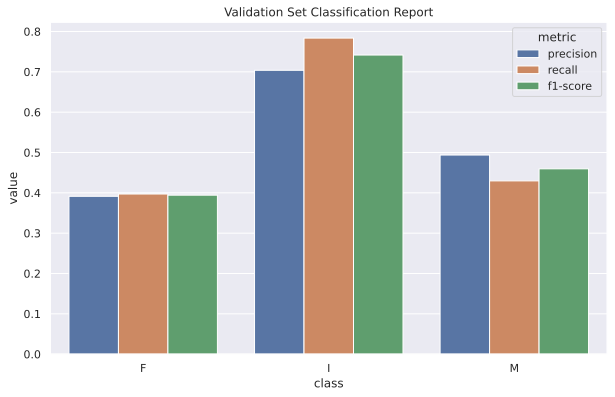

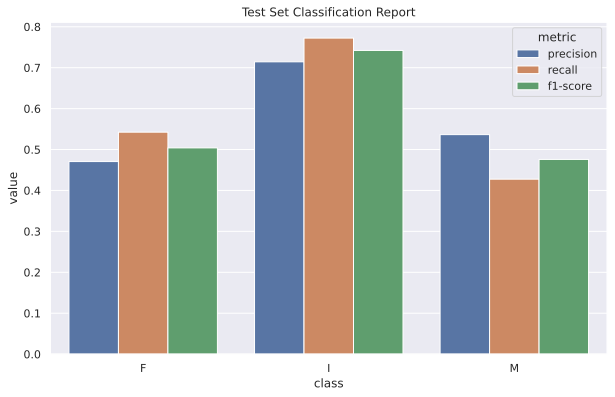

In [ ]:
def plot_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred, output_dict=True)
    classes = list(report.keys())[:-3]
    metrics = ['precision', 'recall', 'f1-score']
    # Write data on class, metric and values to new list
    data = []
    for cls in classes:
        for metric in metrics:
            data.append((cls, metric, report[cls][metric]))
    # Create new dataset for the report
    df = pd.DataFrame(data, columns=['class', 'metric', 'value'])
    # Plot result
    plt.figure(figsize=(10, 6))
    sns.barplot(x='class', y='value', hue='metric', data=df)
    plt.title(title)
    plt.show()

# Validation set classification report
plot_classification_report(y_val_2, y_val_pred_best_2, 'Validation Set Classification Report')

# Test set classification report
plot_classification_report(y_test_2, y_test_pred_best_2, 'Test Set Classification Report')


################## END OF THE NOTEBOOK #######################